# **Introduction**

Nous avons travaillé sur les méthodes proposées dans l'article *Dimension Independent Matrix Square using MapReduce (DIMSUM)*.

L'article développe une solution générale pour pour calculer le produit $A^TA$ avec $A$ une matrice sparse de taille $n \times m$ avec $m >> n$.  On considère typiquement des matrices de grande taille avec $m \approx 10^{13}$ et $n \approx 10^4$. L'algorithme proposé fait appel à la méthode MapReduce pour paralléliser les calculs.

La plupart des méthodes de calculs de $A^TA$ nécessitent d'avoir accès à la totalité de la matrice $A$ sur une seule machine ou bien d'échanger un grand nombre d'informations entre les machines, ce qui n'est pas faisable pour les valeurs de $m$ considérées. Une matrice de cette taille ne peut être stockée ou streamée sur une seule machine, ce qui nécessite d'utiliser un algorithme adapté.

MapReduce est utilisé pour gérer une grande quantité de données (ici la matrice de taille $m \times n$) en distribuant le calcul sur plusieurs machines. L'algorithme présenté se base sur la décomposition en valeurs singulières d'une matrice de taille $m \times n$ avec au plus $L$ valeurs non-nulles par ligne (sparsité). La décomposition en valeurs singulirères (SVD) de $A$ s'écrit: $A = UΣV^T$, avec $U$ et $V$ deux matrices unitaires de tailles $m \times m$ et $n \times n$. L'article développe un algorithme permettant de calculer le produit $A^TA$ sans dépendance à $m$ et fournit une borne supérieure pour l'erreur.

**Objectif:** Calculer le produit $A^TA$ avec $A$ une matrice $m \times n$  ($m >> n$)

# **I. Algorithmes et implémentations**

*(Les codes proposés dans cette parties ne sont pas utilisables directement. La version utilisable de ces codes se trouve dans la partie dédiée aux tests et à la présentation du code)*

## **A. Algorithmes**

### **1) Version brute**

Une première méthode de calcul consiste en une implémentation non-parallélisée du calcul.

**Algorithme brut**


**for** all $r_i$ in A:  
$\space\space$**for** all pairs ($a_{ij}$,$a_{ik}$) in $r_i$:  
$\space\space\space\space$ Emit ($c_i, c_j$) $→$ $a_{ij} a_{ik}$  
$\space\space$**end for**  
**end for**  
**Output** C




En pratique on utilise **Numpy** pour effectuer ce calcul "brut"


```
N = A.T.dot(A)
```

Comme évoqué dans l'introduction, cette implémentation n'est pas utilisable en pratique pour les matrices considérées (stockage de la matrice et temps de calcul).

### **2) Version parallèle naïve**

Une première version naïve faisant appel à un mapper et un reducer est proposée dans le papier. 

**Mapper naïf $(r_i)$**  
$\space\space\space\space$**for** all pairs ($a_{ij}$,$a_{ik}$) in $r_i$:  
$\space\space\space\space\space\space$ Emit ($c_i, c_j$) $→$ $a_{ij} a_{ik}$  
$\space\space\space\space$**end for**
  


---


**Reducer naïf $((c_i,c_j),<v_1, … , v_R>)$**  
$\space\space\space\space$**Output** $c_i^T c_j → ∑_{i = 1}^R v_i$

En pratique, nous avons utilisé **Numpy** pour implémenter simplement cette version

In [ ]:
def mapper(mat, norms_array, gamma):
    return mat.T@mat


def reducer(mat_list, norms_array, gamma):
    return sum(mat_list)

La manière naïve d'effectuer le calcul de $A^TA$ consiste à calculer tous les produits entre les colonnes de la matrice $A$ et à paralléliser le calcul.
On peut voir que l'implémentation naïve de MapReduce a une compléxité en $O(mL^2)$, ce qui est infaisable pour les matrices étudiées. 

### **3) Version parallèle efficace**

Pour un algorithme MapReduce, il existe deux sources principales de complexité:


*   une complexité liée aux communications entre les machines ("shuffle-size")
*   une complexité liée à la surcharge potentielle d'une matrice ("reduce-key")

Il est possible de réduire significativement les deux complexités avec l'algorithme DIMSUM proposé dans l'article. Dans ce cas, le reducer renvoie une variable aléatoire dont l'espérance est une normalisation des paramètres de $A^TA$. Il est en particulier possible de montrer que, pour un seuil ϵ donné, la complexité liée à la charge d'une machine ("reduce-key") est en $O(\frac{n^2}{ϵ^2})$, donc indépendante de $m$.

On choisit dans ce cas un $\gamma$, l'algorithme efficace s'écrit comme suit:

**Mapper DIMSUM $(r_i)$**  
$\space\space\space\space$**for** all pairs ($a_{ij}$,$a_{ik}$) in $r_i$:  
$\space\space\space\space\space\space$ With probability $min(1,\gamma \frac{1}{||c_j|| \cdot ||c_k||})$    
$\space\space\space\space\space\space\space\space\space\space$ Emit ($c_i, c_j$) $→$ $a_{ij} a_{ik}$  
$\space\space\space\space$**end for**
  


---


**Reducer DIMSUM $((c_i,c_j),<v_1, … , v_R>)$**  
$\space\space\space\space$**Output** $b_{ij} → \frac{1}{min(\gamma,||c_j|| \cdot ||c_k||)} ∑_{i = 1}^R v_i$

En voici, une version en Python

In [ ]:
def mapper(mat, norms_array, gamma):
    gamma_copy = gamma
    nrow, ncol = mat.shape
    output = np.zeros((ncol, ncol)) # note that ncol << nrow, so the for loops are OK
    for i_output in range(ncol):
        for j_output in range(ncol):
            # randomly choose pairs
            random_values = np.random.rand(nrow)
            probas = gamma_copy/(norms_array[i_output]*norms_array[j_output])*np.ones((nrow,))
            bool_vect = (probas < random_values)
            # sum chosen pairs
            output[i_output, j_output] = np.sum(mat[bool_vect, i_output]*mat[bool_vect, j_output])
    return output


def reducer(mat_list, norms_array, gamma):
    return 1/np.minimum(np.outer(norms_array, norms_array), gamma)*sum(mat_list)

### **4) Reduire le nombre de calculs**

Dans l'algorithme présenté précedemment, il est nécessaire de générer $\binom{L}{2}$ nombre aléatoires pour chaque ligne. Ceci ne nécessite pas de communication entre les machines mais impose toujours un grand nombre de calcul. L'article propose de réduire le nombre de calcul en modifiant le Mapper précédent.

**Lean Mapper DIMSUM $(r_i)$**  
$\space\space\space\space$**for** all $a_{ij}$ in $r_i$:  
$\space\space\space\space\space\space$ With probability $min(1,\sqrt{\gamma} \frac{1}{||c_j||})$     
$\space\space\space\space\space\space\space$**for** all $a_{ik}$ in $r_i$:  
$\space\space\space\space\space\space\space\space\space$ With probability $min(1,\sqrt{\gamma} \frac{1}{||c_k||})$    
$\space\space\space\space\space\space\space\space\space\space\space\space\space$ Emit ($c_i, c_j$) $→$ $a_{ij} a_{ik}$  
$\space\space\space\space\space\space\space$**end for**  
$\space\space\space\space$**end for**

Le reducer reste inchangé.

## **B. Résultats théoriques**

L'article donne quelques résultats sur la précision et la correction de l'algorithme DIMSUM.  
Le **théorème 2** permet de borner la distance entre le résultat de l'algorithme et la valeur réelle de $A^TA$ en fonction du $\gamma$ choisi et de n (avec une probabilité supérieure à $\frac{1}{2}$).  
Le **théorème 3** propose une seconde borne pour la distance avec des hypothèses relachées.  
Les **théorèmes 4, 5 et 6** contrôlent le nombre de calcul et les communications entre les machines.



## **C. Technologies utilisées** 

Dans une logique d'optimisation de la performance de nos algorithmes, nous avons comparé l'usage de 2 structures de données différentes pour stocker les matrices: 


*   Stockage sous forme de **dictionnaires Python**
*   Stockage sous forme d'**arrays Numpy**



Comme suggéré dans l'article nous avons utilisé un algorithme MapReduce pour gérer en parallèle le grand nombre d'entrées de la matrice A. La très grande taille de la matrice (plusieurs gigaoctets) ainsi que la contrainte temporelle nous ont amenés à distribuer le calcul via les algorithmes présentés dans la partie I.A.

L'implémentation des algorithmes a été effectuée avec Python en faisant appel aux bibliothèques ```multirocessing``` et ```threading``` dont nous avons cherché à comparer les performances sur différentes matrices.



**Multiprocessing**  
Ce package permet le recours à des sous-process pour effectuer des calculs en parallèle. Il propose en particulier la fonction ```Pool``` pour gérer simplement les multiples sous-process utilisés



**Threading**  
Ce package permet de générer et de gérer différents threads pour effectuer les calculs en parallèle. 

La bibliothèque ```numpy``` a été utilisée pourn définir et manipuler les matrices plus simplement. Il est a noter que ```numpy``` fait déjà appel à des méthodes d'optimisation de la performance lors de calculs de matrices. Ce que nous avons pu confirmer en étudiant l'utilisation des différents coeurs de nos machines lors de l'appel à une version non-parallélisée du calcul. Pour résoudre ce problème et contrôler nous-même la performance, nous avons imposé à ```numpy``` de ne faire appel qu'à un seul coeur lors de l'execution, afin de contrôler la parallèlisation indépendemment.


```
# force numpy to use only a single processor, by changing the environment of the underlying libraries
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"
import numpy as np
```





# **II. Résultats et interprétation**

## **A. Cadre de test**

Les tests ont été effectués sur des matrices sparses telles que $m = 50$ (50 colonnes) possédant 5 valeurs non nulles par ligne, avec $n$ allant de $2^{10}$ à $2^{22}$. La répartition des calculs sur les threads ou sur les process est effectuée en découpant la matrice d'entrée suivant les lignes (data parallelism), puis en allouant une sous-matrice à chaque thread / process.

Les objets passés à chaque thread / process sont copiés et bien distincts afin de contourner le GIL.
Afin d'assurer la comparabilité des deux algorithmes du papier (appelés "naive" et "final" dans le code) sur les deux structures de données (tableaux et dictionnaires), les opérations ne sont pas effectuées de la même manière:
- Pour la structure de donnée tableau numpy, les opérations sont effectuées avec les fonctions de numpy, limitées à un seul CPU (car la répartition par CPU est déjà effectuée à travers la répartition entre les threads / process).
- Pour les dictionnaires, les opérations sont effectuées avec du code Python (cela ralentit l'exécution par rapport à numpy mais cela permet d'effectuer une comparaison de temps de calcul entre les deux algorithmes).




## **B. Résultats**

Résultats pour la structure de donnée tableau numpy ($log_2(n)$ en abscisse):

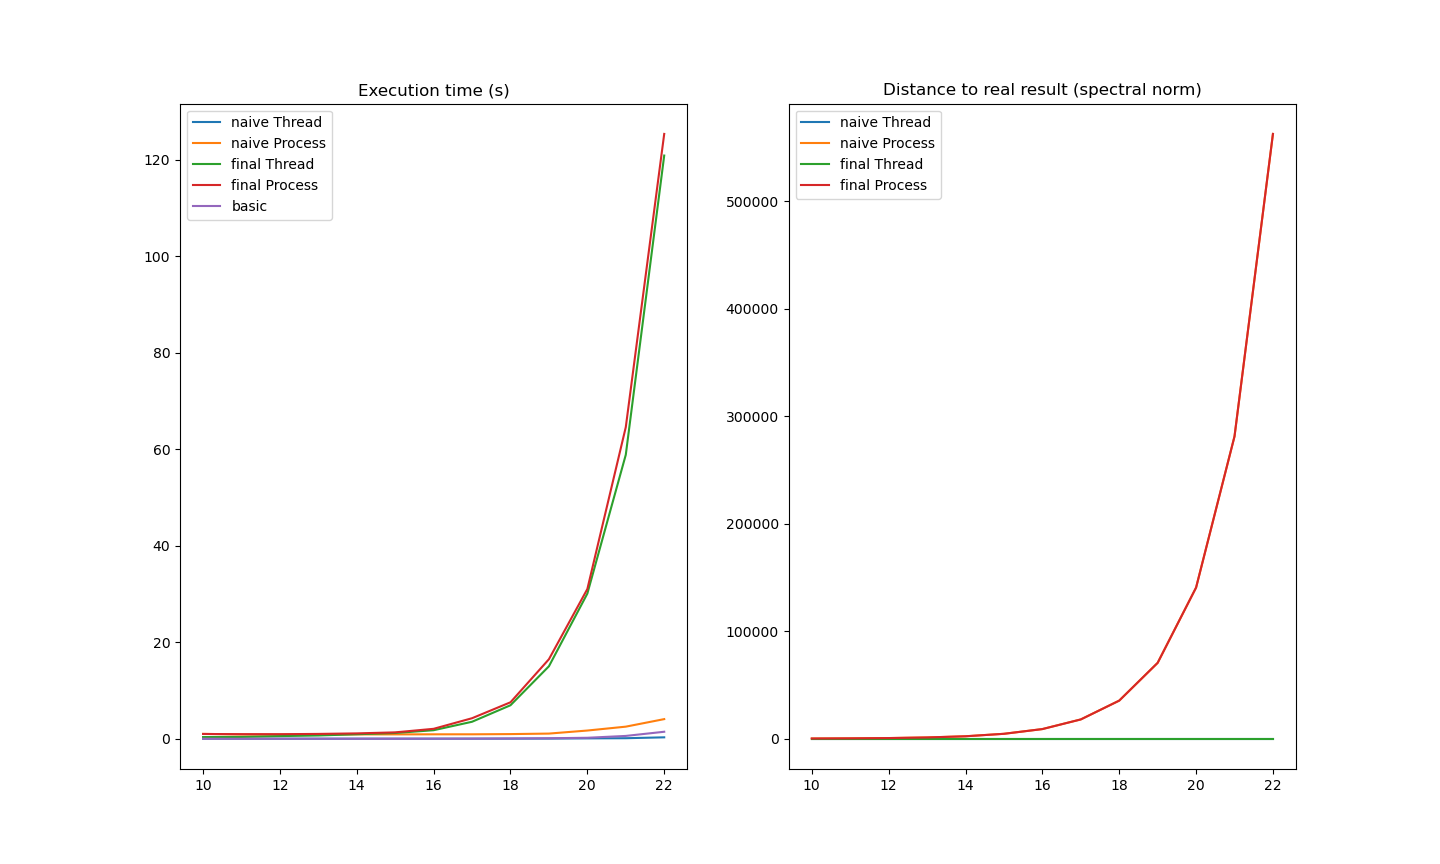

L'algorithme le plus efficace est ici l'algorithme parallélisé naïf, qui divise effectivement le temps d'exécution par presque 6 (nombre de CPU utilisés). L'algorithme du papier est nettement moins efficace sur cette structure de données. C'est assez intuitif car le fait que la matrice soit sparse n'est pas utilisé ici, les zéros sont traités comme les autres valeurs.

Résultats pour la structure de données dictionnaire:

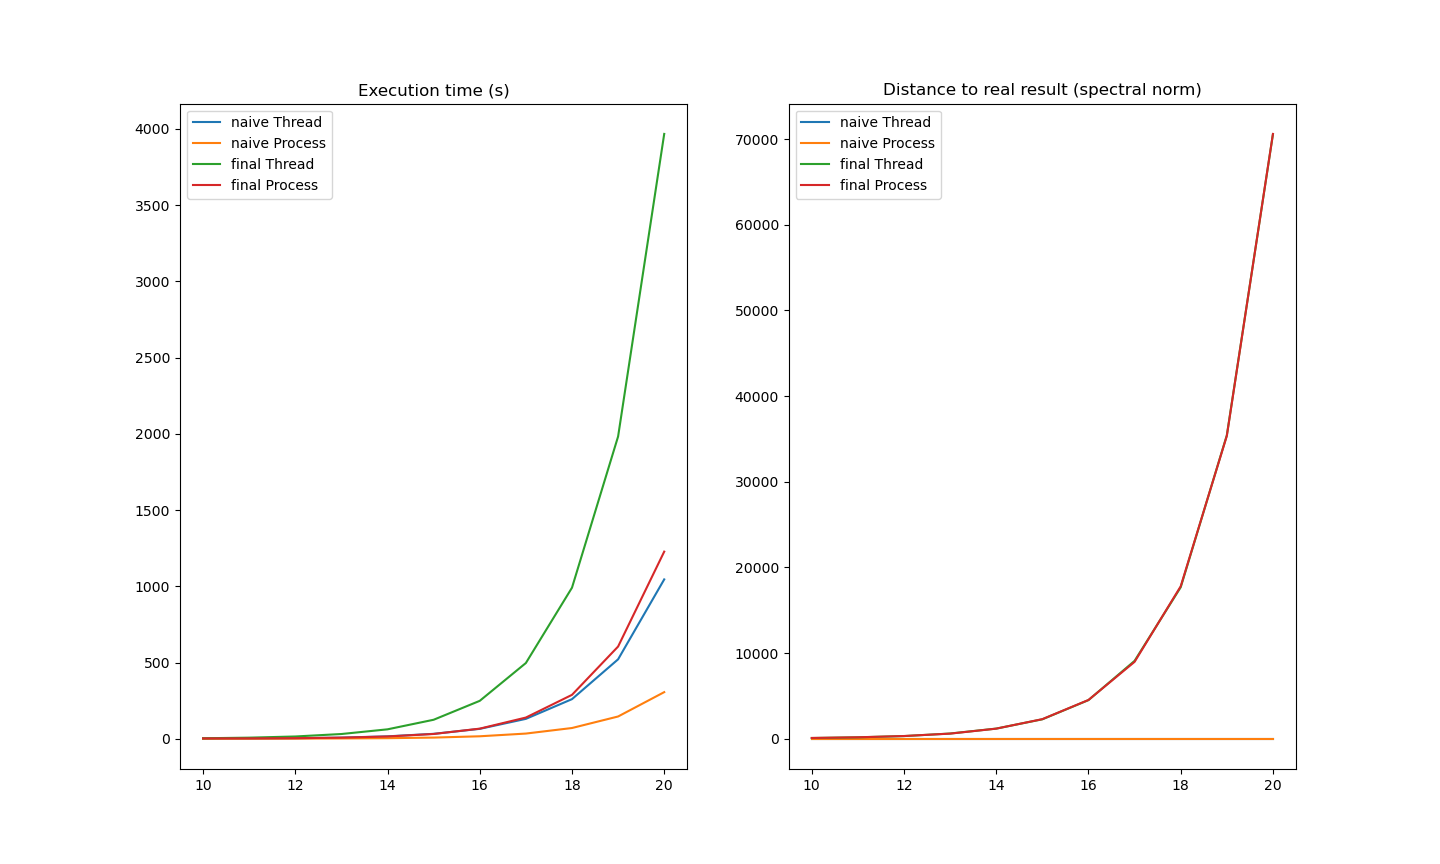

Dans cette implémentation basée sur du code Python et des dictionnaires, la solution naïve reste plus efficace, mais l'ordre est inversé entre threads et process. Il est difficile de savoir d'où vient cette inversion car les threads sont normalement plus rapides. L'interprétation la plus crédible est que le coût lié à l'accès à l'environnement d'exécution est ici plus élevé pour les threads que pour les process en raison d'une concurrence, peut-être sur l'accès à l'implémentation du dictionnaire en Python.

Par ailleurs, la différence entre les deux algorithmes du papier est nettement plus réduite avec cette implémentation. 
Le fait que l'algorithme du papier ne soit pas plus efficace peut s'interpréter en réalité de trois manières: 
- soit l'hypermaramètre gamma est mal calibré
- soit la matrice de test n'est pas assez sparse (elle contient 10% de valeurs non-nulles, ce qui représente une proportion assez importante)
- soit le générateur aléatoire implique en arrière-plan un accès concurrent aux valeurs aléatoires

## **C. Accès au code**

Voici le lien git


Commentaire: les listes des matrices de test list_big_matrix_python.pickle et list_big_matrix_np.pickle sont absentes de git car elles sont trop volumineuses

# **Conclusion**

Nous avons étudié différentes implémentations de l'algorithme DIMSUM pour estimer le produit $A^TA$ pour une matrice A de taille $m \times n$ ($m >> n$) indépendemment de m. De fait, il est possible d'estimer ce produit pour des cas en grande dimension où les méthodes usuelles échouent. Il est en particulier possible d'utiliser cet algorithme pour estimer la valeur du produit $A^TA$ dans des problèmes de régression linéaires: $A^TAx = A^Ty$ avec un certain nombre de garanties.
